# fig_egHFA

### This notebook generates example activation functions from various electrodes. It has functions to plot all examples by various grouping criteria (e.g., region or cluster)
    
    

In [1]:
%%capture
### import packages
import numpy as np
import pandas as pd
import mne
import json as json
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
import pingouin as pg
import random as rd
import pickle
import os
import subprocess
import pycircstat as circ
import fooof as ff
import tensorpac as tp
from sklearn.metrics import r2_score,pairwise_distances,roc_auc_score,balanced_accuracy_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# ccdt_func
import ccdt_func as cc



# plot in separate windows, interactive
from matplotlib.backends import _tkagg
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 



# Collect Group Data
C = cc.Collection(collection_lbl='all')

# get task stats
C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# filter only include good electrodes 
C.filterElectrodes(filtE_bool= np.array(C.isBadElectrode_list)==False)

# cluster based on features
C.clusterElectrodesByTaskStats(feat_option = 'selectivity_rtOnly',binarize_stats=True)

# create fig dir
fig_dir = os.getcwd()+'/figs/afig_r1/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
def clean_fig(apply_int=True,n_bins = 3):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],n_bins))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],n_bins))
    if apply_int==True:
        plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=20)
        plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)    
    
def plotClusEg(C,cut_level,clus_id):
    # ret_idx
    ret_idx = C.clus_cut_tree[:,cut_level]==clus_id

    # calc num subj
    C.evalClus_taskstatsTimeCourse(ret_idx,str(cut_level)+'-'+str(clus_id))

def plotRegEg(C,roi,save_dir):
    
    # get anat Df 
    anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
    
    ret_idx = anatDf['roi'].to_numpy()==roi
    
    C.evalClus_taskstatsTimeCourse(ret_idx,save_dir)
    
def calcStats(uElbl):
    uElbl.split('-')[0]
    
    SE = cc.SubjElectrode(subj=uElbl.split('-')[0],elec1_lbl=uElbl.split('-')[1],\
                          elec2_lbl=uElbl.split('-')[2])

    SE.doTaskStats_2d(pow_frange_lbl = 'HFA',
    pow_method = 'wave',
    pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
    do_zscore = True,
    apply_gauss_smoothing = True,
    gauss_sd_scaling = 0.075,num_iters=1000,
    apply_time_bins=False,overwriteFlag =False,feat_list_beh =['zrrtStoch'])
 
    return SE    


In [2]:
%%capture
# ILLUSTRATE  Time series to HFA methods
# eg. time course (time series to HFA)

# ilustrate method of studying clean data (from CC to Response for brain state dynamics)
uElbl = 'HUP179-RC1-RC2'
SE = calcStats(uElbl)
SE.getEEG(eeg_evType='CC',eeg_filt_fRange=(70,200))
SE.getPow_2d(pow_evType = 'CC',pow_frange_lbl = 'HFA',pow_method = 'wave',apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=False)

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:6254: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.pow_ev_filt = self.pow_ev_filt.append(self.E[i].pow_ev_filt)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:6254: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.pow_ev_filt = self.pow_ev_filt.append(self.E[i].pow_ev_filt)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:6254: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.pow_ev_filt = self.pow_ev_filt.append(self.E[i].pow_ev_filt)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:6254: FutureWarning: The frame.append method is deprecated and will be 

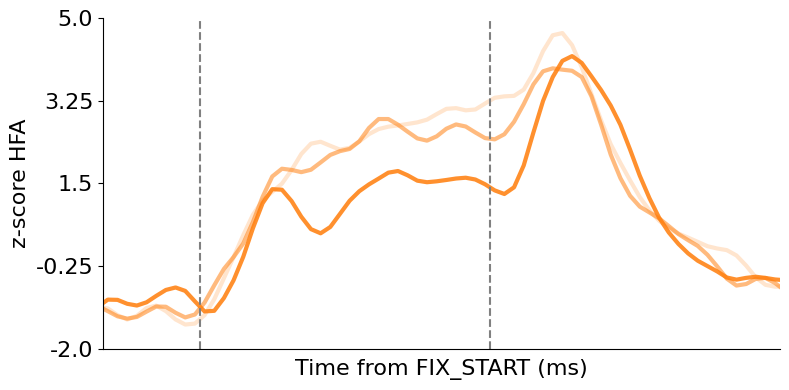

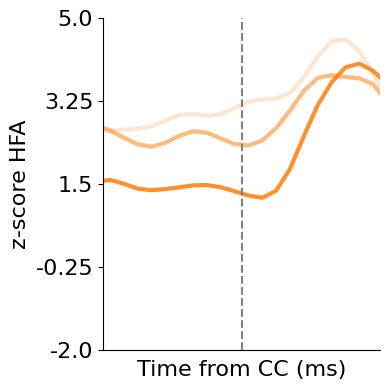

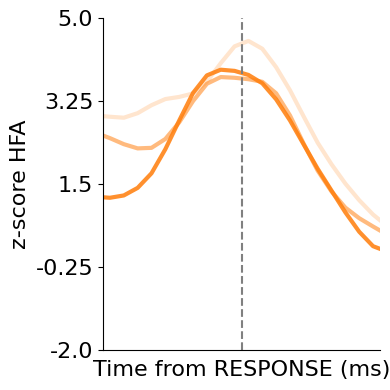

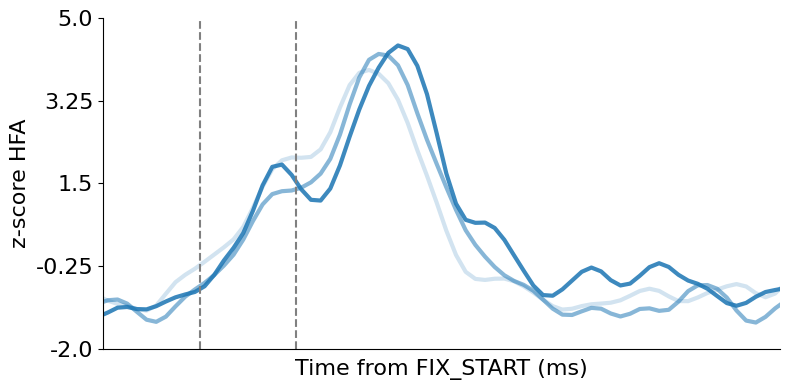

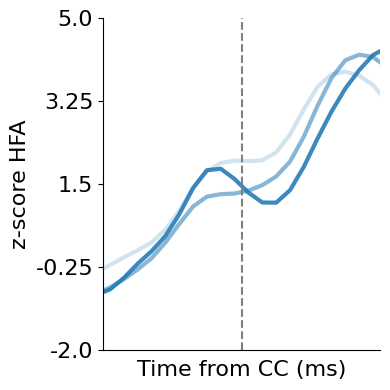

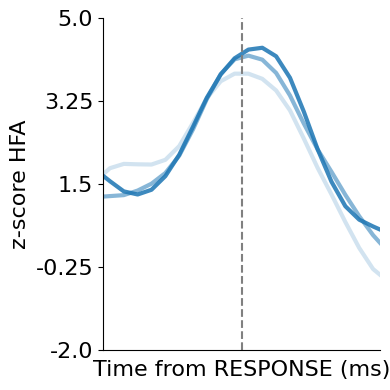

In [11]:
def plotPowByRT(SE,num_bins=10,delays_list=[1500]):
    #f = plt.figure(figsize=(10,5))
    #ax = plt.subplot(131)
    SE.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50)
    SE.plotPowByRT_2d(ax = None, xL_ms=(-500,3000),num_bins=num_bins,figsize=(8,4),delays_list=delays_list,add_vline=False)
    plt.gca().set_xticks([])
    plt.gca().vlines([],plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
    if 500 in delays_list:
        plt.gca().vlines([0,500],plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5')
    if 1500 in delays_list:
        plt.gca().vlines([0,1500],plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5')
    
    save_fig('powByRT-targOn-'+SE.subj+'-'+SE.eLbl+'-'+str(num_bins)+str(delays_list))

    #ax = plt.subplot(132)
    SE.getPow_2d(pow_evType='CC',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50)
    SE.plotPowByRT_2d(ax = None,xL_ms=(-500,500),num_bins=num_bins,figsize=(4,4),delays_list=delays_list,add_vline=False)
    plt.gca().set_xticks([])
    plt.gca().vlines([0],plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5') 
    save_fig('powByRT-CC-'+SE.subj+'-'+SE.eLbl+'-'+str(num_bins)+str(delays_list))

    #ax = plt.subplot(133)
    SE.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50)
    SE.plotPowByRT_2d(ax = None,xL_ms=(-500,500),num_bins=num_bins,figsize=(4,4),delays_list=delays_list,add_vline=False)
    plt.gca().set_xticks([])
    plt.gca().vlines([0],plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5') 
    save_fig('powByRT-Response-'+SE.subj+'-'+SE.eLbl+'-'+str(num_bins)+str(delays_list))
# plot example RT relations

plotPowByRT(SE,num_bins=3,delays_list=[1500])
plotPowByRT(SE,num_bins=3,delays_list=[500])

In [15]:
#np.arange(0,100,10)

print(np.linspace(0,100,4))

np.min([(0.2+100/100),1])

[  0.          33.33333333  66.66666667 100.        ]


1.0